In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/My Drive/FDA Things/BioBert/biobert

/content/drive/My Drive/FDA Things/BioBert/biobert


In [3]:
!pip install transformers

In [4]:
! CUDA_LAUNCH_BLOCKING="1"

In [5]:
from sklearn.metrics import roc_auc_score

# Function to calculate area under the curve, helper function for training & eval
def get_AUC(preds, labels):

    flat_master_preds = [item for sublist in preds for item in sublist]
    flat_master_truth = [item for sublist in labels for item in sublist]

    std_preds = [x[1] - x[0] for x in flat_master_preds]
    res = roc_auc_score(flat_master_truth, std_preds)
    return res

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Functions to calculate the accuracy of our predictions vs labels, helper functions for training and eval

# Supports drugbank
def flat_accuracy(preds, labels, DrugBank=False):
    # print('got these as inputs:\n\n', 'preds:', preds, '\nlabels:', labels)
    condensed_preds = []
    for subl in preds:
        if subl[0] > subl[1]:
          condensed_preds.append(0)
        else:
          condensed_preds.append(1)

    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    if not DrugBank:
      tn, fp, fn, tp = confusion_matrix(labels, condensed_preds).ravel()    
      return [np.sum(pred_flat == labels_flat) / len(labels_flat), tp, fp, tn, fn]

    if DrugBank:
      return [np.sum(pred_flat == labels_flat) / len(labels_flat)]

# Used for joint_model
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [7]:
def print_model_info(model):
    # Get all of the model's parameters as a list of tuples.
    params = list(model.named_parameters())
    print('The BERT model has {:} different named parameters.\n'.format(len(params)))
    print('==== Embedding Layer ====\n')

    for p in params[0:5]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    print('\n==== First Transformer ====\n')
    
    for p in params[5:21]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    for p in params[-20:-4]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

    print('\n==== Output Layer ====\n')
    for p in params[-4:]:
        print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [8]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [9]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

def environment_setup(verbose = False, PATH="/content/drive/My Drive/FDA Things/paranoia4_no_commas.csv"):

    """
    Parses Data from a .csv file.
    
    Returns:::
    train_sentences: 1d np array of length 6195
    train_labels: 1d np array of length 6195
    test_sentences: 1d np array of length 1549
    test_labels: 1d np array of length 1549
    device: torch.device
    """

    # If there's a GPU available...
    if torch.cuda.is_available():    

        # Tell PyTorch to use the GPU.    
        device = torch.device("cuda")

        if verbose:
            print('There are %d GPU(s) available.' % torch.cuda.device_count())
            print('We will use the GPU:', torch.cuda.get_device_name(0))

    # If not...
    else:
        if verbose: print('No GPU available, using the CPU instead.')
        device = torch.device("cpu")

    # Opting for binary classification instead of multi-class classification
    data = pd.read_csv(PATH)
    data = data[data.columns[-3:]].copy() # removing all the extraneous numbers
    clean_data = pd.DataFrame({'text': data.iloc[:,1], 'label': data.iloc[:,2]})
    clean_data = clean_data.replace(to_replace={'u': 0, '4': 0, '3': 0, '/': 0, 'c': 0, '2': 0, '1': 1, '0': 0, '': 0}, value=None)
    clean_data = clean_data.fillna(0)


    # making sure data
    clean_data.astype({'label': 'int'}).dtypes
    train_df, eval_df = train_test_split(clean_data, test_size=0.2)
    train_df.iloc[:,1] = train_df.iloc[:,1].astype('int64')

    eval_df.iloc[:,1] = eval_df.iloc[:,1].astype('int64')
    eval_df = eval_df.astype(str)
    eval_df['label'] = eval_df['label'].astype(int)

    # Report the number of sentences.
    if verbose:
        print('Number of training sentences: {:,}\n'.format(df.shape[0]))

    train_sentences = train_df.text.values
    train_labels = train_df.label.values

    test_sentences = eval_df.text.values
    test_labels = eval_df.label.values

    return train_sentences, train_labels, test_sentences, test_labels, device

# DIVIDING LINE

In [10]:
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler
import copy

def tokenize_and_organize_data(tokenizer, sentences, labels, verbose=False, max_sentence_length=64, BATCH_SIZE=32):

    """
    Produces a dataloader from a tokenizer, sentences, and labels.

    Parameters:::
    tokenizer: Tokenizer object (e.g. transformers.tokenization_distilbert.DistilBertTokenizer object)
    sentences: 1d np array
    labels: 1d np array

    Returns:::
    train_sentences: 1d np array of length .8*sentences
    train_labels: 1d np array of length .8*sentences
    test_sentences: 1d np array of length .2*sentences
    test_labels: 1d np array of length .2*sentences
    device: torch.device
    """

    if verbose:
        # Print the original sentence.
        print(' Original: ', sentences[0])

        # Print the sentence split into tokens.
        print('Tokenized: ', tokenizer.tokenize(sentences[0]))

        # Print the sentence mapped to token ids.
        print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

    # Tokenize all of the sentences and map the tokens to their word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        sent = str(sent)
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = max_sentence_length,           # Pad & truncate all sentences.
                            truncation = True,
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                      )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    if verbose:
        # Print sentence 0, now as a list of IDs.
        print('Original: ', sentences[0])
        print('Token IDs:', input_ids[0])

    # Combine the training inputs into a TensorDataset.
    dataset = TensorDataset(input_ids, attention_masks, labels)

    # The DataLoader needs to know our batch size for training, so we specify it 
    # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
    # size of 16 or 32.
    batch_size = BATCH_SIZE

    # We'll take training samples in random order. 
    dataloader = DataLoader(
                dataset,  # The training samples.
                sampler = RandomSampler(dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )
    
    return dataloader

In [11]:
from transformers import get_linear_schedule_with_warmup, AdamW


def load_model(model, epochs, train_dataloader):

    """
    Produces object to aid in the model's training.

    Parameters:::
    model: some transformers model (e.g. <class 'transformers.modeling_distilbert.DistilBertForSequenceClassification'>)
    train_dataloader: a pytorch dataloader 

    Returns:::
    scheduler: torch.optim.lr_scheduler.LambdaLR object
    optimizer: transformers.optimization.AdamW object
    """

    model = model.cuda()
    print_model_info(model)

    # Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
    # I believe the 'W' stands for 'Weight Decay fix"
    optimizer = AdamW(model.parameters(),
                      lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                      eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                    )

    # Total number of training steps is [number of batches] x [number of epochs]. 
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    
    return scheduler, optimizer

In [12]:
import random
import numpy as np
import pandas as pd


def train_model(model, epochs, train_dataloader, validation_dataloader, scheduler, optimizer, device, seed_val = 42):


    """
    Trains the model & evaluates every epoch.

    Parameters:::
    [self-explanatory]

    Returns:::
    flat_master_preds: a list of logit outputs
    model: the trained model
    flat_master_truth: a list of length 0.8*sentences of integers
    hidden_states: a list of length 0.8*sentences/batch size, where each element is a torch.Tensor of size [batch size, features]
    """

    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    # Set the seed value all over the place to make this reproducible.

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            # print('step:', step, '\n\nbatch is a', type(batch), 'of length ', len(batch), 'where each element is ', batch[0].shape, "\n\n")

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2]
            b_labels = b_labels.long()
            b_labels = b_labels.to(device)
            
            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.

            # Some models don't play well with token_type_ids; you may need to comment/uncomment the next two lines as needed.

            # loss, logits, _ = model(b_input_ids, 
            #                     token_type_ids=None, 
            #                     attention_mask=b_input_mask,
            #                     labels=b_labels)
            
            loss, logits, _ = model(b_input_ids, 
                                attention_mask=b_input_mask,
                                labels=b_labels)

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()


        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        tn = 0
        fp = 0
        fn = 0
        tp = 0
        master_preds = []
        master_truth = []
        hidden_state_list = []

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].long().to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.



                # Same situation as before; model.forward sometimes dislikes a token_type_ids depending on the model

                # loss, logits, hidden_states = model(b_input_ids, 
                #                       token_type_ids=None, 
                #                       attention_mask=b_input_mask,
                #                       labels=b_labels)
                
                loss, logits, hidden_states = model(b_input_ids, 
                                      attention_mask=b_input_mask,
                                      labels=b_labels)

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            master_preds.append(logits)
            master_truth.append(label_ids)
            # print('hidden_states is a tuple of size: ', len(hidden_states), ' where each entry has shape: ', hidden_states[len(hidden_states) - 1].shape, '. We are adding this slice of that to our hidden state list', hidden_states[len(hidden_states) - 1][:,0,:].shape)
            hidden_state_list.append(hidden_states[len(hidden_states) - 1][:,0,:])
            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.

            flat_acc_res = flat_accuracy(logits, label_ids)
            total_eval_accuracy += flat_acc_res[0]
            tp += flat_acc_res[1]
            fp += flat_acc_res[2]
            tn += flat_acc_res[3]
            fn += flat_acc_res[4]
            

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        print('Confusion matrix::: \n', 'tp: ', tp, 'fp: ', fp, 'tn: ', tn, 'fn: ', fn)
        print(get_AUC(master_preds, master_truth))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

    # ----------

    # Display floats with two decimal places.
    pd.set_option('precision', 2)

    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')

    # Display the table.
    print(df_stats)

    flat_pred_list = [item for sublist in master_preds for item in sublist]
    flat_master_truth = [item for sublist in master_truth for item in sublist]
    # print('final input embeddings:\n\n', model.get_input_embeddings()) # included here for ease of adapting this code

    return flat_pred_list, flat_master_truth, model, hidden_state_list


In [13]:
def just_eval_model(model, validation_dataloader, device='cpu', debug=False, AUC=False, drugBank=False):


        """
        Evaluates the model.

        Parameters:::
        [self-explanatory]

        Returns:::
        flat_pred_list: a list of logit outputs
        flat_master_truth: a list of length 0.8*sentences of integers
        hidden_states_list: a list of length 0.8*sentences/batch size, where each element is a torch.Tensor of size [batch size, features]
        """

        print("")
        print("Running Validation...")

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model = model.to(device).eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        tn = 0
        fp = 0
        fn = 0
        tp = 0
        master_preds = []
        master_truth = []
        hidden_states_list = []

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            if debug:
              print('b_labels shape:', b_labels.shape)
              print('b_input shape:', b_input_ids.shape)
              print('b_input mask shape:', b_input_mask.shape)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here: 
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                loss, logits, hidden_states = model(b_input_ids, 
                                      attention_mask=b_input_mask,
                                      labels=b_labels)
                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            master_preds.append(logits)
            master_truth.append(label_ids)

            # some fancy indexing to get the vectors associated with the [CLS] token for the last layer
            hidden_states_list.append(hidden_states[len(hidden_states) - 1][:,0,:])

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            
            flat_acc_res = flat_accuracy(logits, label_ids, drugBank)
            total_eval_accuracy += flat_acc_res[0]


            if not drugBank:
              tp += flat_acc_res[1]
              fp += flat_acc_res[2]
              tn += flat_acc_res[3]
              fn += flat_acc_res[4]
              

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
                
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))

        if not drugBank: print('Confusion matrix::: \n', 'tp: ', tp, 'fp: ', fp, 'tn: ', tn, 'fn: ', fn)
        if AUC: print(get_AUC(master_preds, master_truth))

        print("")
        print("Testing complete!")

        flat_pred_list = [item for sublist in master_preds for item in sublist]
        flat_master_truth = [item for sublist in master_truth for item in sublist]
        return flat_pred_list, flat_master_truth, hidden_states_list


In [14]:
from transformers import BertTokenizer, AutoTokenizer, AlbertTokenizer, DistilBertTokenizer
from transformers import BertForSequenceClassification, AutoModelWithLMHead, RobertaConfig, BertForMaskedLM, BertConfig, AlbertForSequenceClassification, RobertaForSequenceClassification, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased", do_lower_case=True)
tokenizer2 = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", output_hidden_states=True)
model2 = BertForSequenceClassification.from_pretrained("bert-base-uncased", output_hidden_states=True)

epochs = 1
epochs2 = 1



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [15]:
train_sentences, train_labels, test_sentences, test_labels, device = environment_setup()
train_dataloader = tokenize_and_organize_data(tokenizer, train_sentences, train_labels)
validation_dataloader = tokenize_and_organize_data(tokenizer, test_sentences, test_labels)
scheduler, optimizer = load_model(model, epochs, train_dataloader)
# passing in train_dataloader twice to evaluate on the training set every epoch
_, flat_master_truth, trained_model, hidden_states = train_model(model, epochs, train_dataloader, train_dataloader, scheduler, optimizer, device)


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


The BERT model has 104 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (30522, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)
distilbert.transformer.layer.0.attention.q_lin.weight     (768, 768)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm.weight           (

In [16]:

train_dataloader2 = tokenize_and_organize_data(tokenizer, train_sentences, train_labels)
validation_dataloader2 = tokenize_and_organize_data(tokenizer, test_sentences, test_labels)
scheduler2, optimizer2 = load_model(model2, epochs2, train_dataloader2)
_, flat_master_truth2, trained_model2, hidden_states2 = train_model(model2, epochs2, train_dataloader2, train_dataloader2, scheduler2, optimizer2, device)


The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [17]:
flat_hidden_states = [item for sublist in hidden_states for item in sublist]
flat_hidden_states2 = [item for sublist in hidden_states2 for item in sublist]

# so NOW, each element of the list is a sentence vector (so flat_hidden_states is a list of 1d tensors of size [features])
# and flat_master_truth is a list that has corresponding labels


In [18]:
# t-SNE business

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from sklearn.manifold import TSNE

def plot_tSNE(data, truths, start=0, amt=2000):

  """
  Constructs a tSNE plot.

  Parameters:::
  Kind of picky for data type. 
  
  data: a list of length 0.8*sentences, where each element is a list of length [features]
  truths: a list of the same length, where each element is an integer

  These next parameters are to reduce computation time (~7000 vectors of ~750 elements takes quite a while)
  start: at what point in the outermost list to start counting points for the tSNE
  amt: the number of points to include

  """

  new_array = np.array(data)
  tsne = TSNE(n_components=2, random_state=0)
  y = truths[start:(start+amt)]
  data_X = new_array[start:(start+amt)]
  tsne_obj= tsne.fit_transform(data_X)
  tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        'label':y})

  sns.scatterplot(x="X", y="Y",
              hue="label",
              palette=['red','blue'],
              legend='full',
              data=tsne_df);




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


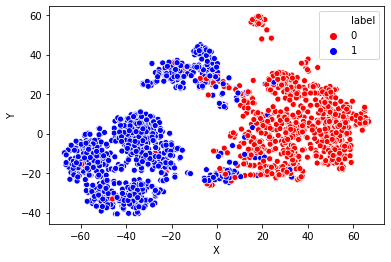

In [19]:
array_hidden_states = []
for i in flat_hidden_states:
  array_hidden_states.append(list(i))

array_hidden_states2 = []
for i in flat_hidden_states2:
  array_hidden_states2.append(list(i))


plot_tSNE(array_hidden_states, flat_master_truth)

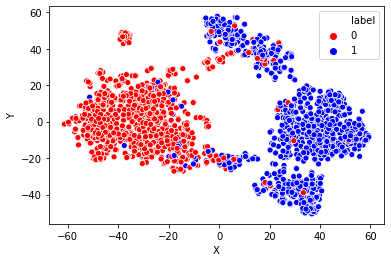

In [20]:
plot_tSNE(array_hidden_states2, flat_master_truth2, 2000)

In [21]:
# So now, we take our hidden states extracted from each model, and stack them together. 
# joined_lists is an np array of length 0.8*sentences, where each element is another np array of length 2, where each element of that inner array is a tensor of size [features]

joined_lists = np.column_stack([flat_hidden_states, flat_hidden_states2])

In [22]:
# reformatting the data into new_list, which is a list of length 0.8*sentences where each element is an array of size [features from model1 + features from model2]

for ix,iy in np.ndindex(joined_lists.shape):
  joined_lists[ix,iy] = joined_lists[ix, iy].tolist()

new_list = []
for i in joined_lists:
  new_list.append(i[0] + i[1]) # confirmed this is joining those two tensors, not elementwise adding them

# Your model's training starts here

In [23]:
from torch.utils.data import Dataset

EPOCHS = 1
BATCH_SIZE = 64
LEARNING_RATE = 0.001

# Training another model on top of the internal representations of the previous 2 individual models
class trainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data    
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
    def __len__ (self):
        return len(self.X_data)

train_data = trainData(torch.FloatTensor(new_list), 
                       torch.FloatTensor(flat_master_truth))


# Preparing a test dataset for evaluation (currently just the training dataset again, so we can evaluate on the training)
class testData(Dataset):    
    def __init__(self, X_data):
        self.X_data = X_data
    def __getitem__(self, index):
        return self.X_data[index]
    def __len__ (self):
        return len(self.X_data)
    
test_data = testData(torch.FloatTensor(new_list))

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1) 
y_test = flat_master_truth

In [24]:
# This block of code is getting the internal representations of each model for the test set
# Also allows for evaluation of each model individually at this point

# Step 1: Get dataloader for test set
test_dataloader = tokenize_and_organize_data(tokenizer, test_sentences, test_labels, verbose=False)

# Step 2: From that dataloader, make predictions based on our previously trained two individual models
_, test_flat_master_truth_list, test_hidden_states_list = just_eval_model(trained_model, test_dataloader, 'cuda')
_, _, test_hidden_states_list2 = just_eval_model(trained_model2, test_dataloader, 'cuda')

# Step 2b: Go through the same process of putting our data in the right format
test_flat_hidden_states = [item for sublist in test_hidden_states_list for item in sublist]
test_flat_hidden_states2 = [item for sublist in test_hidden_states_list2 for item in sublist]

test_joined_lists = np.column_stack([test_flat_hidden_states, test_flat_hidden_states2]) # np.column_stack([flat_pred_list, flat_pred_list2])

for ix,iy in np.ndindex(test_joined_lists.shape):
  test_joined_lists[ix,iy] = test_joined_lists[ix, iy].tolist()

test_new_list = []
for i in test_joined_lists:
  test_new_list.append(i[0] + i[1])

# Step 3: Now put that test data into a Dataset, then a DataLoader

actual_test_data = testData(torch.FloatTensor(test_new_list))
actual_test_loader = DataLoader(dataset=actual_test_data, batch_size=1) 
y_actual_test = test_flat_master_truth_list



Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.18
Confusion matrix::: 
 tp:  787 fp:  57 tn:  660 fn:  45

Testing complete!

Running Validation...
  Accuracy: 0.94
  Validation Loss: 0.18
Confusion matrix::: 
 tp:  791 fp:  54 tn:  663 fn:  41

Testing complete!


In [25]:
import torch.nn as nn
import torch.optim as optim


# Defining our neural network

class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 1536 = 2*[features]
        
        self.const1 = 1536
        self.layer_1 = nn.Linear(1536, self.const1) 
        self.layer_2 = nn.Linear(int(self.const1), int(self.const1/2))
        self.layer_3 = nn.Linear(int(self.const1/2), int(self.const1/4))
        self.layer_4 = nn.Linear(int(self.const1/4), int(self.const1/8))
        self.layer_5 = nn.Linear(int(self.const1/8), int(self.const1/16))
        self.layer_out = nn.Linear(int(self.const1/16), int(1))

        self.relu = nn.LeakyReLU()
        self.dropout = nn.Dropout(p=0.25)

        self.batchnorm1 = nn.BatchNorm1d(self.const1)
        self.batchnorm2 = nn.BatchNorm1d(int(self.const1/2))
        self.batchnorm3 = nn.BatchNorm1d(int(self.const1/4))
        self.batchnorm4 = nn.BatchNorm1d(int(self.const1/8))
        self.batchnorm5 = nn.BatchNorm1d(int(self.const1/16))

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.dropout(x)

        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)

        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)

        x = self.relu(self.layer_4(x))
        x = self.batchnorm4(x)
        x = self.dropout(x)

        x = self.relu(self.layer_5(x))
        x = self.batchnorm5(x)
        x = self.layer_out(x)
        
        return x

In [26]:
# Defining how the model should learn

joint_model = binaryClassification()
joint_model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(joint_model.parameters(), lr=LEARNING_RATE) # trying Adam, Adagrad

In [27]:
from sklearn.metrics import classification_report

# Testing the joint model

def test_on_train(joint_model, test_loader):
    y_pred_list = []
    joint_model = joint_model.eval()
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = joint_model(X_batch).to(device)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    print('TEST ON TRAIN:::')
    print(confusion_matrix(y_test, y_pred_list))
    print(classification_report(y_test, y_pred_list))


def test_joint_model(joint_model, actual_test_loader, drugBank=False):
    y_pred_list_test = []
    joint_model = joint_model.eval()
    with torch.no_grad():
        for X_batch in actual_test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = joint_model(X_batch).to(device)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list_test.append(y_pred_tag.cpu().numpy())

    y_pred_list_test = [a.squeeze().tolist() for a in y_pred_list_test]

    print('--------------------------------------------------\n On Actual Test Set:')
    if not drugBank: print(confusion_matrix(y_actual_test, y_pred_list_test))

    print(classification_report(y_actual_test, y_pred_list_test))

In [28]:
joint_model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = joint_model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    test_on_train(joint_model, test_loader)
    test_joint_model(joint_model, actual_test_loader)

Epoch 001: | Loss: 0.15944 | Acc: 94.330
TEST ON TRAIN:::
[[2780  139]
 [ 115 3161]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2919
           1       0.96      0.96      0.96      3276

    accuracy                           0.96      6195
   macro avg       0.96      0.96      0.96      6195
weighted avg       0.96      0.96      0.96      6195

--------------------------------------------------
 On Actual Test Set:
[[347 370]
 [362 470]]
              precision    recall  f1-score   support

           0       0.49      0.48      0.49       717
           1       0.56      0.56      0.56       832

    accuracy                           0.53      1549
   macro avg       0.52      0.52      0.52      1549
weighted avg       0.53      0.53      0.53      1549



In [29]:
device = 'cuda'

and now a t-SNE for our joint model:


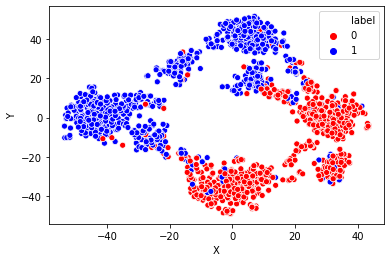

In [30]:
print('and now a t-SNE for our joint model:')
plot_tSNE(test_new_list, test_flat_master_truth_list, 0, 1548)

Now going through the same process for DrugBank indications.

In [31]:
drug_bank_df = pd.read_csv('/content/drive/My Drive/FDA Things/drugbank-indication.tsv', sep='\t') 
clean_drug_bank_df = pd.concat([drug_bank_df[drug_bank_df.columns[-1]], pd.Series([1 for i in range(len(drug_bank_df[drug_bank_df.columns[-1]]))])], axis=1).dropna()
clean_drug_bank_df = clean_drug_bank_df.rename({"indication":"text", 0:"label"})
clean_drug_bank_df.head()


,indication,0
label,For the treatment of heparin-induced thrombocy...,1
1,"Cetuximab, used in combination with irinotecan...",1
2,Used as adjunct therapy in the treatment of cy...,1
3,For treatment of cutaneous T-cell lymphoma,1
4,Etanercept is indicated for the treatment of m...,1


In [32]:
drug_bank_dataloader = tokenize_and_organize_data(tokenizer, clean_drug_bank_df.indication, clean_drug_bank_df[clean_drug_bank_df.columns[-1]].tolist())

In [33]:
db_flat_pred_list, db_flat_master_truth, db_hidden_states_list = just_eval_model(trained_model, drug_bank_dataloader, device='cuda', drugBank=True)



Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.22

Testing complete!


In [36]:
db_flat_pred_list2, _, db_hidden_states_list2 = just_eval_model(trained_model2, drug_bank_dataloader, device='cuda', drugBank=True)


Running Validation...


RuntimeError: ignored

In [ ]:
db_test_flat_hidden_states = [item for sublist in db_hidden_states_list for item in sublist]
db_test_flat_hidden_states2 = [item for sublist in db_hidden_states_list2 for item in sublist]

db_test_joined_lists = np.column_stack([db_test_flat_hidden_states, db_test_flat_hidden_states2]) # np.column_stack([flat_pred_list, flat_pred_list2])
print(db_test_joined_lists[1, 1].shape)

for ix,iy in np.ndindex(db_test_joined_lists.shape):
  db_test_joined_lists[ix,iy] = db_test_joined_lists[ix, iy].tolist()

db_test_new_list = []
for i in db_test_joined_lists:
  db_test_new_list.append(i[0] + i[1])

db_actual_test_data = testData(torch.FloatTensor(db_test_new_list))

db_actual_test_loader = DataLoader(dataset=db_actual_test_data, batch_size=1) 
y_actual_test = db_flat_master_truth


In [ ]:
test_joint_model(joint_model, db_actual_test_loader, drugBank=True)

# Results History


Joint model:
```
[[666  46]
 [ 42 795]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       712
           1       0.95      0.95      0.95       837

    accuracy                           0.94      1549
   macro avg       0.94      0.94      0.94      1549
weighted avg       0.94      0.94      0.94      1549
```

First individual model:

```
Running Validation...
  Accuracy: 0.94
  Validation Loss: 0.50
Confusion matrix::: 
 tp:  795 fp:  47 tn:  665 fn:  42
0.9745143839018432

Testing complete!
```

Second individual model:

```
Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.40
Confusion matrix::: 
 tp:  781 fp:  64 tn:  648 fn:  56
0.9685842965110816

Testing complete!
```


-----------
